In [61]:
import numpy as np
import pandas as pd
import os
import string
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics
import cv2
from sklearn.model_selection import GridSearchCV


dataset = pd.read_csv("leaves.csv")
dataset.head(5)

X = dataset.iloc[:,2:]

y = dataset['species']
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 135)
X_train.head(5)


#skaliranje
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


In [53]:
import mahotas as mt
import re
import matplotlib
import matplotlib.pyplot as plt

In [62]:
parameters = [{'kernel': ['rbf'],
               'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
               'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
             ]
svm_clf = GridSearchCV(svm.SVC(decision_function_shape='ovr'), parameters)
svm_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [63]:
svm_clf.best_params_

{'C': 100, 'kernel': 'linear'}

In [64]:
clf = svm.SVC(C=100.0, decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',)
clf.fit(X_train,y_train)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [12]:
# filename = 'finalized_model2.sav'
# pickle.dump(clf, open(filename, 'wb'))
# pickle.dump(sc_X, open('standard_scaler2.sav', 'wb'))

In [65]:
y_pred = clf.predict(X_test)

metrics.accuracy_score(y_test, y_pred)

0.9092495636998255

In [34]:
def preprocess_leaf(image):
  names = ['area','perimeter','pysiological_length','pysiological_width','aspect_ratio','rectangularity','circularity', \
        'mean_r','mean_g','mean_b','stddev_r','stddev_g','stddev_b', \
        'contrast','correlation','inverse_difference_moments','entropy'
      ]
  df = pd.DataFrame([], columns=names)
  gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#         plt.imshow(gray,cmap='Greys_r')
#         plt.show()

  blur = cv2.GaussianBlur(gray, (55,55),0)
#         plt.imshow(blur,cmap='Greys_r')
#         plt.show()

  ret,otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#         plt.imshow(otsu,cmap='Greys_r')
#         plt.show()

  kernel = np.ones((50,50),np.uint8) 
#         plt.imshow(kernel,cmap='Greys_r')
#         plt.show()

  closing = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel) #mask
  # plt.imshow(closing,cmap='Greys_r')
  # plt.show()

  contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  len(contours)

  cnt = contours[0]
  len(cnt)

  area = cv2.contourArea(cnt)
  perimeter = cv2.arcLength(cnt,True)

#species = find_species(file) #prima naziv photografije "file"
#Shape features
  x,y,w,h = cv2.boundingRect(cnt)
  aspect_ratio = float(w)/h
  rectangularity = w*h/area
  circularity = ((perimeter)**2)/area


#Color features
  red_channel = img[:,:,0]
  green_channel = img[:,:,1]
  blue_channel = img[:,:,2]
  blue_channel[blue_channel == 255] = 0
  green_channel[green_channel == 255] = 0
  red_channel[red_channel == 255] = 0

  red_mean = np.mean(red_channel)
  green_mean = np.mean(green_channel)
  blue_mean = np.mean(blue_channel)

  red_std = np.std(red_channel) 
  green_std = np.std(green_channel)
  blue_std = np.std(blue_channel)

#Texture features
  textures = mt.features.haralick(gray)
  ht_mean = textures.mean(axis=0)
  contrast = ht_mean[1]
  correlation = ht_mean[2]
  inverse_diff_moments = ht_mean[4]
  entropy = ht_mean[8]

  vector = [area,perimeter,w,h,aspect_ratio,rectangularity,circularity,\
      red_mean,green_mean,blue_mean,red_std,green_std,blue_std,\
      contrast,correlation,inverse_diff_moments,entropy]
  df_temp = pd.DataFrame([vector],columns=names)
  df = df.append(df_temp)
  return df

In [48]:
train_df = pd.read_csv("train.csv")

In [51]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)


In [52]:
leaf_box = train_df.loc[train_df['image_id'] == "LEAF_0714.jpg"]
print(leaf_box)

           image_id  width  height      x      y      w      h
4057  LEAF_0714.jpg    416     416   76.0    5.0  171.0  247.0
4058  LEAF_0714.jpg    416     416   16.0  229.0  188.0   53.0
4059  LEAF_0714.jpg    416     416  221.0  135.0  187.0  191.0
4060  LEAF_0714.jpg    416     416    9.0  281.0  225.0   98.0


In [46]:
classes = []
def find_class(leaf_features):
  scaled_features = sc_X.transform(leaf_features)
  print(scaled_features)
#  print(scaled_features)
# y_pred_mobile = svm_clf.predict(features_of_img)
  y_pred_mobile = clf.predict(scaled_features)
  classes.append(y_pred_mobile[0])

In [43]:
def find_outpt(classes):
   return max(set(classes), key = classes.count)

def calculate_percent(classes, class_index):
  result = classes.count(class_index)*100.0/len(classes)
  return result

def get_name(class_index):
  common_names = ['pubescent bamboo','Chinese horse chestnut','Anhui Barberry', \
                'Chinese redbud','true indigo','Japanese maple','Nanmu',' castor aralia', \
                'Chinese cinnamon','goldenrain tree','Big-fruited Holly','Japanese cheesewood', \
                'wintersweet','camphortree','Japan Arrowwood','sweet osmanthus','deodar','ginkgo, maidenhair tree', \
                'Crape myrtle, Crepe myrtle','oleander','yew plum pine','Japanese Flowering Cherry','Glossy Privet',\
                'Chinese Toon','peach','Ford Woodlotus','trident maple','Beales barberry','southern magnolia',\
                'Canadian poplar','Chinese tulip tree','tangerine'
               ]
  return common_names[class_index]

In [44]:
def find_contour(cnts, resized_image):
    contains = []
    y_ri,x_ri, _ = resized_image.shape
    for cc in cnts:
        yn = cv2.pointPolygonTest(cc,(x_ri//2,y_ri//2),False)
        contains.append(yn)

    val = [contains.index(temp) for temp in contains if temp>0]
    print(contains)
    return val[0]

In [45]:
def background_remover(img):
  gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gs, (55,55),0)
  ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  plt.imshow(im_bw_otsu,cmap='Greys_r')
  kernel = np.ones((50,50),np.uint8)
  closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
  closing = 255 - closing  # ako su pikeli u intervalu [0,255] ovo je ok, a ako su u intervalu [0.,1.] onda bi bilo 1. - img
  plt.imshow(closing,cmap="Greys_r")
  plt.show()
  contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  print(len(contours))
  h, w, c = img.shape
  black_img = np.empty([h,w,c],dtype=np.uint8)
  black_img.fill(0)
  plt.imshow(black_img,cmap="Greys_r")
  index = find_contour(contours, img)
  cnt = contours[index]
  mask = cv2.drawContours(black_img, [cnt] , 0, (255,255,255), -1)
  plt.imshow(mask)
  maskedImg = cv2.bitwise_and(img, mask)
  
  white_pix = [255,255,255]
  black_pix = [0,0,0]

  final_img = maskedImg
  h,w,channels = final_img.shape
  for x in range(0,w):
      for y in range(0,h):
          channels_xy = final_img[y,x]
          if all(channels_xy == black_pix):    
              final_img[y,x] = white_pix
  plt.imshow(final_img)
  return final_img

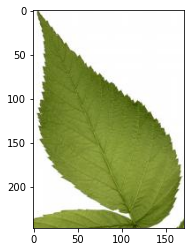

[[-2.32384929 -5.01373371 -6.91977491 -3.19026797 -1.5814478  -0.3338958
  -0.2153509   2.66428708  2.38289517  3.75269911  4.22480277  1.52881696
   3.06350768  6.59598613 -9.02035324 -2.52289929  2.34254774]]


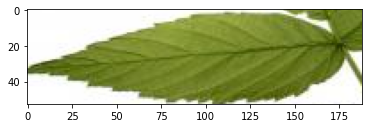

[[ -2.39860341  -5.61215749  -6.81775193  -4.14568853   3.4585414
   -0.43347466  -0.19108821   2.66428708   2.38289517   3.75269911
    4.22480277   1.52881696   3.06350768  16.55313262 -24.58752301
   -4.29451558   3.43756336]]


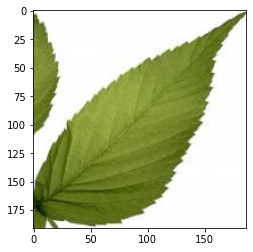

[[-2.34988873 -5.01314978 -6.82375328 -3.46605947 -1.07521796 -0.29217121
  -0.0126413   2.66428708  2.38289517  3.75269911  4.22480277  1.52881696
   3.06350768  7.72790351 -9.51667003 -2.2411502   2.26802539]]


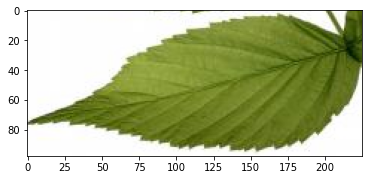

[[ -2.36984057  -5.46044429  -6.75173705  -3.92407036   0.78120238
   -0.41252441  -0.34356994   2.66428708   2.38289517   3.75269911
    4.22480277   1.52881696   3.06350768  10.87430552 -13.42087977
   -3.33531949   2.943966  ]]
Found classes:  [3, 9, 3, 3]
This plant is  75.0  percent  Chinese redbud


In [54]:
#Identifying plant
# detektovani listovi sa upisanim koordinatama
img = cv2.imread("LEAF_0714.jpg")
classes = []
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)
for index, row in leaf_box.iterrows():
  crop_img = original_img[int(row['y']):int(row['y'])+int(row['h']), int(row['x']):int(row['x'])+int(row['w'])]
  #crop_img = background_remover(crop_img)
  plt.imshow(crop_img)
  plt.show()
  leaf_features = preprocess_leaf(crop_img)
  find_class(leaf_features)
print("Found classes: ", classes)
leaf_class = find_outpt(classes)
result = calculate_percent(classes, leaf_class)
print("This plant is ", result, " percent ", get_name(leaf_class))
  #plt.imshow(crop_img)
  #print(row['x'], row['y'], row['w'], row['h'])

In [74]:
#prepoznavanje lista kada na slici ima jedan list
img = cv2.imread("1.jpg")
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)
classes = []

leaf_features = preprocess_leaf(original_img)
print(leaf_features)

X_test = sc_X.transform(leaf_features)
y_pred = clf.predict(X_test)
print(y_pred)

      area    perimeter pysiological_length pysiological_width  aspect_ratio  \
0  51214.0  1332.925967                 617                120      5.141667   

   rectangularity  circularity      mean_r      mean_g      mean_b   stddev_r  \
0        1.445698    34.691523  223.491163  239.857546  236.316202  74.835073   

    stddev_g   stddev_b   contrast  correlation  inverse_difference_moments  \
0  32.954426  41.047277  21.045037     0.992468                     0.87381   

    entropy  
0  4.235698  
[2]
